In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 1000
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
sym = 'GC'
start_date='20190101'
end_date='20191231'
periods=[5,10,20,40,80,160]
s='20180501'
params = {
    'bollir': calibrate_multiple(sym, bolli_reduced, start_date=s),
    'ema': calibrate_multiple(sym, ema, start_date=s),
    'breakout': calibrate_multiple(sym, breakout, start_date=s),
    'carver': calibrate_multiple(sym, carver, start_date=s),
    'roc': calibrate_multiple(sym, roc, start_date=s)
}
inds = {
    'bollir': simulate(params['bollir'], sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    #'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=periods),
    'carver': simulate(params['carver'], sym, carver, start_date=start_date, end_date=end_date, periods=periods),
    'roc': simulate(params['roc'], sym, roc, start_date=start_date, end_date=end_date, periods=periods)
}
weights = {
    'bollir': .5, 
    'ema': .25, 
    'breakout': .25,
    #'carver': .1,
    #'roc': .1,
}

In [10]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
bollir,9.71588,6.45791
breakout,9.43758,6.59892
carver,7.75633,5.50142
roc,9.75651,6.51793


In [11]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,bollir,breakout,carver,roc
bollir,1.000000,0.927516,0.927971,0.874281
breakout,0.927516,1.000000,0.913397,0.835055
carver,0.927971,0.913397,1.000000,0.919243
roc,0.874281,0.835055,0.919243,1.000000


In [12]:
c.sum()

bollir      3.729768
breakout    3.675968
carver      3.760610
roc         3.628579
dtype: float64

In [13]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()})
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df

In [14]:
data=combine(inds,)

In [15]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.791175205727015, 6.035693759556357)

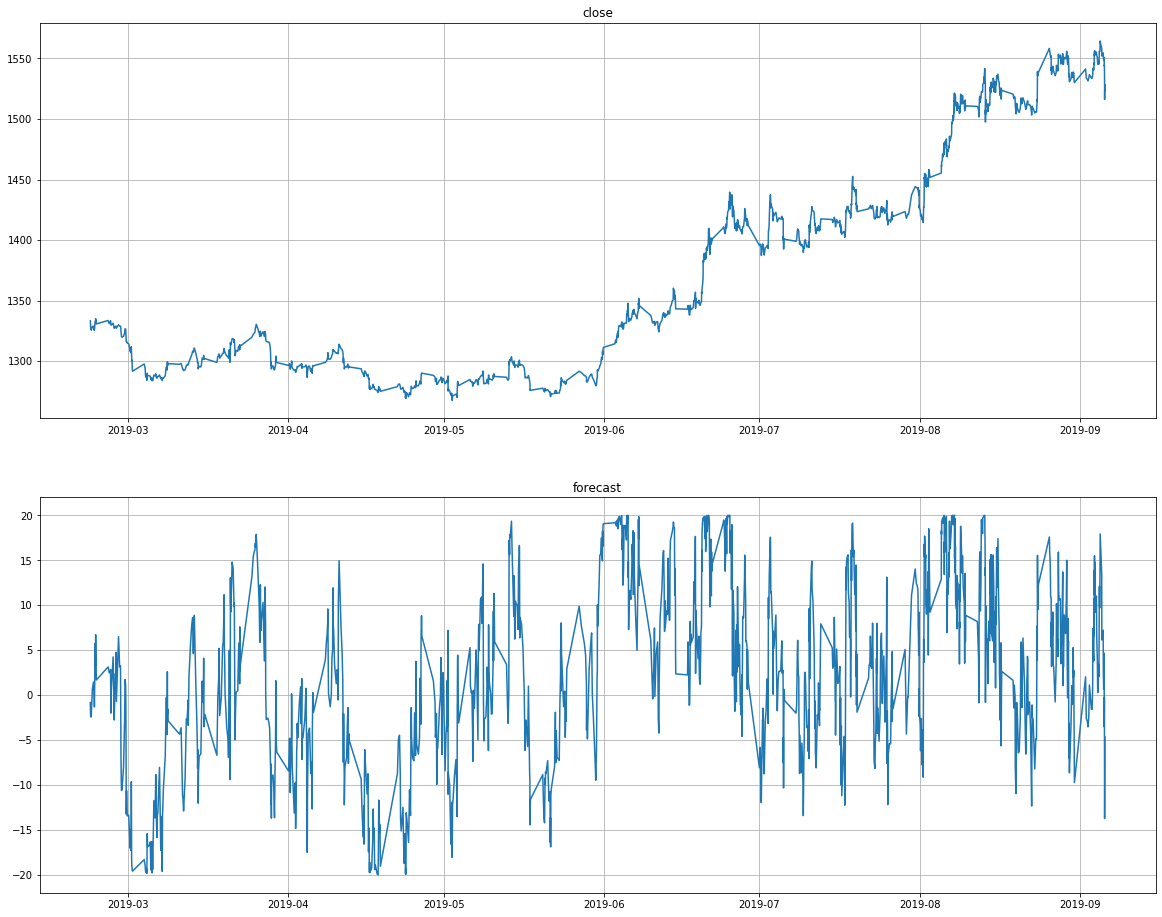

In [16]:
plot(data[['close', 'forecast']])

In [17]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.00525724,0.0569232,0.0979871,0.104018,0.11445,0.175158,0.0584218,0.124366,0.0488332
Cumulative returns,0.00295902,0.0316878,0.0540864,0.0573451,0.0629635,0.0952131,0.0325118,0.0682823,0.0272305
Annual volatility,0.132397,0.115814,0.0993905,0.096778,0.0929322,0.0791819,0.0618759,0.0528271,0.0402449
Sharpe ratio,0.105165,0.535299,0.989759,1.07047,1.21212,2.07801,0.94814,2.24542,1.20466
Calmar ratio,0.0691685,0.917114,1.95787,2.21342,2.58843,4.95173,1.90633,6.85781,2.87314
Stability,0.0198691,0.216404,0.50078,0.563644,0.674443,0.697544,0.596002,0.691407,0.410238
Max drawdown,-0.0760063,-0.0620677,-0.0500479,-0.0469944,-0.0442162,-0.0353731,-0.0306462,-0.0181349,-0.0169964
Omega ratio,1.01866,1.10054,1.20074,1.22311,1.26856,1.64684,1.32169,2.28271,1.68142
Sortino ratio,0.159294,0.897941,1.78324,1.95893,2.31107,4.80558,2.28732,7.08276,2.82249
Skew,0.487571,0.968745,1.29862,1.38838,1.5507,2.41491,3.86826,3.98164,4.07736


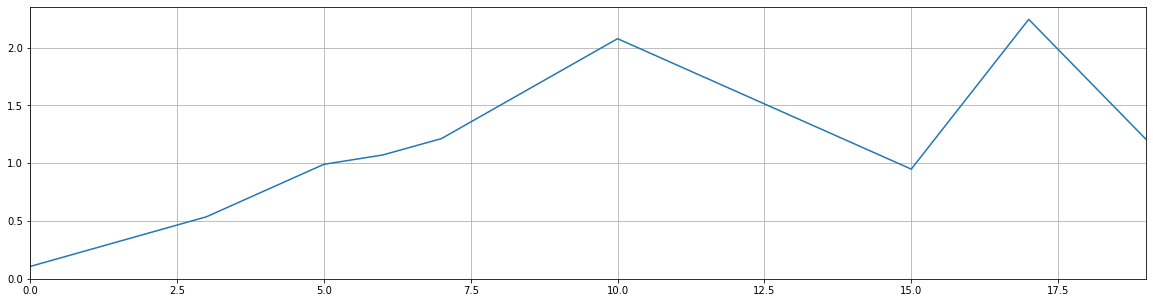

In [18]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [19]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.907647,0.825184,0.790845,0.749326,0.662583,0.451870,0.399456,0.336592
3,0.907647,1.000000,0.917212,0.887065,0.843401,0.704276,0.493718,0.438791,0.371269
5,0.825184,0.917212,1.000000,0.965859,0.925502,0.775710,0.590930,0.540201,0.466113
6,0.790845,0.887065,0.965859,1.000000,0.952850,0.780077,0.594090,0.543468,0.479292
7,0.749326,0.843401,0.925502,0.952850,1.000000,0.835953,0.649750,0.589598,0.530962
10,0.662583,0.704276,0.775710,0.780077,0.835953,1.000000,0.763576,0.678166,0.633058
15,0.451870,0.493718,0.590930,0.594090,0.649750,0.763576,1.000000,0.876226,0.816859
17,0.399456,0.438791,0.540201,0.543468,0.589598,0.678166,0.876226,1.000000,0.857326
19,0.336592,0.371269,0.466113,0.479292,0.530962,0.633058,0.816859,0.857326,1.000000


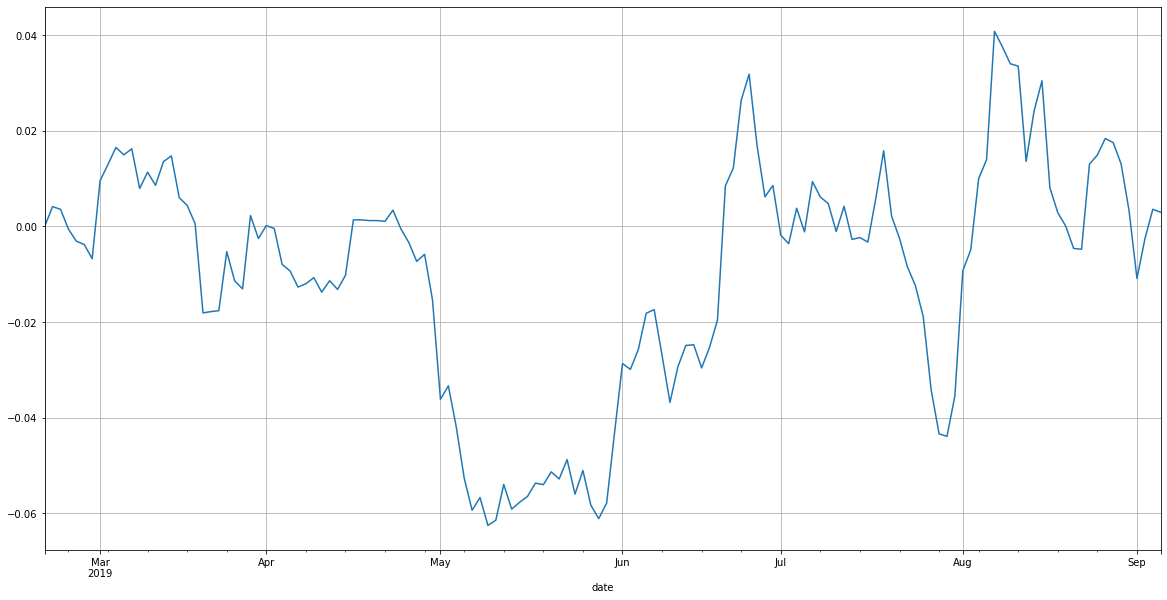

In [20]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

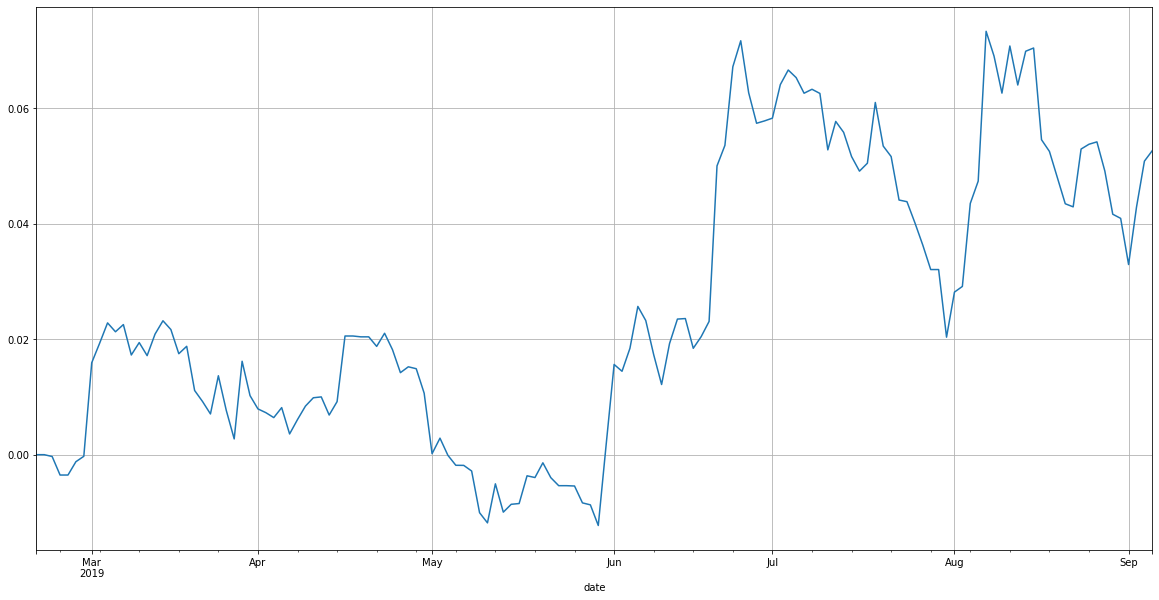

In [21]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

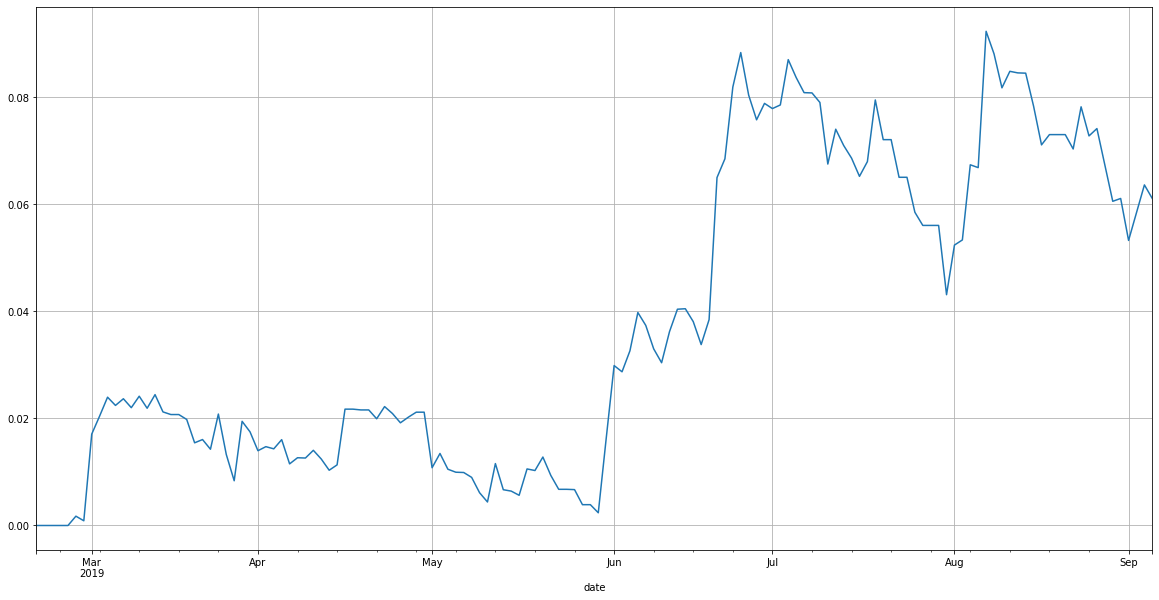

In [22]:
np.log(out.returns[7]+1).cumsum().plot(figsize=(20, 10), grid=True);

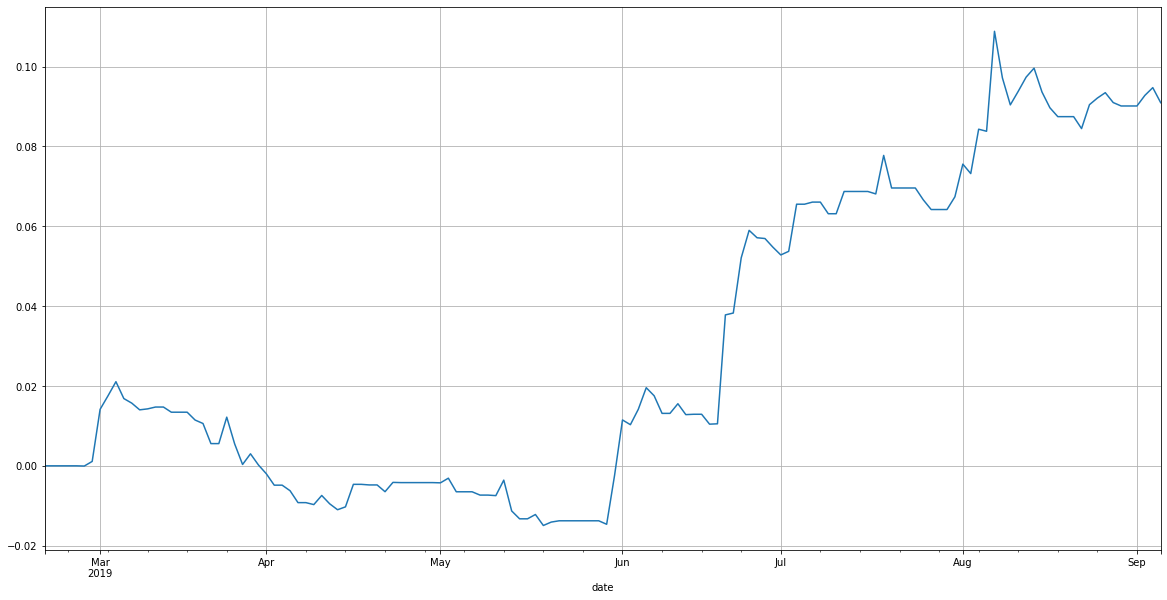

In [23]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);